<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/feature_demosaic_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Thu Apr  1 21:12:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! unzip -q /content/drive/MyDrive/blender_512.zip -d scenes

# feature demosaic net
#### Qian Huang
#### Mar 31

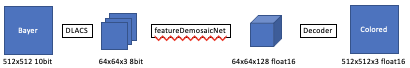

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))


# functions to show an image
def imshow(img, rescale = True):
    npimg = img.numpy()
    if rescale:
        npimg = (np.clip(npimg, 0, 8)/8)
    npimg = npimg**0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

In [5]:
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

## Dataloader
can provide:
* net input: compressed features (64x64x3)
* net output: compressed features (64x64x128)

*camera module*

In [6]:
import skimage.measure

class camMosaicModel:
    def __init__(self):
        ''' params that are from experiments on EVETAR camera '''
        self.sigma_r = 5.3e-4
        self.sigma_s = 8.9e-5
        self.bit_depth = 10
        self.black_level = 50
        ''' params that are NOT from experiments on EVETAR camera '''
        self.amplitude = 2 * 64 * 4

    def noise_model(self, img_gt):
        '''
        follow the noise model of signal-dependent normal distribution
        '''
        sigma_noise = np.sqrt(self.sigma_r**2 + self.sigma_s*img_gt)
        noise = np.random.randn(*img_gt.shape) * sigma_noise
        img_noisy = img_gt + noise
        return img_noisy

    def rgb2bayer(self, img):
        '''
        filter a full RGB frame to be a raw frame.
        '''
        h, w, c = img.shape
        bayer_img = np.zeros((h, w))
        bayer_img[::2, ::2] = img[::2, ::2, 0]
        bayer_img[1::2, 1::2] = img[::2, ::2, 2]
        bayer_img[::2, 1::2] = img[::2, 1::2, 1]
        bayer_img[1::2, ::2] = img[1::2, ::2, 1]
        return bayer_img

    def spatial_sampling(self, img, pix = 1):
        h, w, c = img.shape
        return skimage.measure.block_reduce(img, (pix,pix, 1), np.sum)

    
    def develop(self, img_gt):
        '''
        develop raw frame from ground truth via the noise model, quantization, CFA.
        '''
        img = self.spatial_sampling(img_gt)
        img_noisy = self.noise_model(img)
        sensor_noisy = np.clip(np.round(img_noisy * self.amplitude) + self.black_level,
                               0, 2**self.bit_depth)
        sensor_noisy_float = (sensor_noisy - self.black_level)/(2**self.bit_depth - self.black_level)
        bayer_noisy = self.rgb2bayer(sensor_noisy)
        bayer_noisy_float = self.rgb2bayer(sensor_noisy_float)
        return sensor_noisy.astype(np.uint16), sensor_noisy_float, bayer_noisy.astype(np.uint16), bayer_noisy_float

*DLACS module*

In [7]:
import h5py

class DLACS:
    def __init__(self):
        self.bit_proc = 10 #bit depth for operation
        self.Nchans = 3
        self.Q_scales = [1/4, -1/4, -1/8]
        self.codes = {}
        for i_c in range(self.Nchans):
            fname = 'code_881_chan_%d.h5'%(i_c)
            ftmp=h5py.File(fname,'r')
            tmp=ftmp['data'][:]
            self.codes[i_c] = tmp.astype(np.float32)

    def mask_operation(self, data_tmp, code_1_chan,tmp_type=np.float64):
        cshape = code_1_chan.shape
        nx = int(data_tmp.shape[0]/cshape[0]); ny = int(data_tmp.shape[1]/cshape[1])
        comp1c = np.zeros([nx,ny],dtype=tmp_type)
        for ix in range(nx):
            xs = ix*cshape[0]; xe = xs+cshape[0]
            for iy in range(ny):
                ys = iy*cshape[1]; ye = ys+cshape[1]
                comp1c[ix,iy] = np.sum(data_tmp[xs:xe,ys:ye]*code_1_chan) 

        return comp1c

    def compression_Numpy(self, Data_in, codes_in = None, Q_scales_in=None, 
                          Q_type=np.uint8, tmp_type=np.float64):
        if codes_in is None:
            codes_in = self.codes
        if Q_scales_in is None:
            Q_scales_in = self.Q_scales
        assert(len(codes_in)==len(Q_scales_in))
        cshape = codes_in[0].shape
        assert(Data_in.shape[0]%cshape[0]==0 and Data_in.shape[1]%cshape[1]==0)
        nx = int(Data_in.shape[0]/cshape[0]); ny = int(Data_in.shape[1]/cshape[1])
        
        comp = np.zeros([nx,ny,len(codes_in)],dtype=tmp_type)
        for i in range(len(codes_in)):
            comp[:,:,i] = self.mask_operation(Data_in, codes_in[i][:,:,0,0], tmp_type=tmp_type)
            comp[:,:,i] = comp[:,:,i]*Q_scales_in[i]
            
        # Quantization steps below. Actual hardware running can change tmp_type etc. for simplification
        comp = comp/(np.power(2,self.bit_proc))
        comp = np.floor(comp)
        comp = comp.astype(Q_type)
        return comp

*data loader*

* comp: compressed input features
* Y: 512x512x3 float16 pixel map

In [8]:
import os
import cv2

class demoDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True):
        self.root = root
        self.train = train

    def __len__(self):
        if self.train:
            return 1600
        else:
            return 400
    
    def __getitem__(self, index):
        if self.train:
            Y = load_exr(os.path.join(self.root, "scene{:04d}".format(index//100), 
                                  "Image", "Image{:04d}.exr".format(index % 100 + 1)))
        else:
            Y = load_exr(os.path.join(self.root, "scene{:04d}".format(index//100 + 16), 
                                  "Image", "Image{:04d}.exr".format(index % 100 + 1)))
        _, _, bayer_noisy, _ = camMosaicModel().develop(Y)
        comp = DLACS().compression_Numpy(bayer_noisy)
        Y = torch.from_numpy(Y.transpose(2, 0, 1)).float()
        comp = torch.from_numpy(comp.transpose(2, 0, 1)).float()/255.0
        return comp, Y

In [9]:
trainset = demoDataset(root='/content/scenes', train=True) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testset = demoDataset(root='/content/scenes', train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

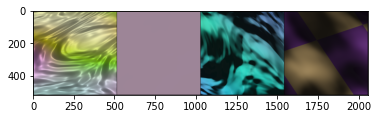

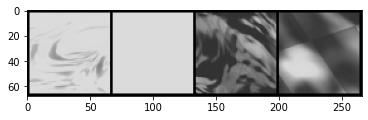

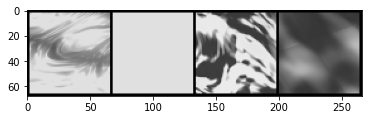

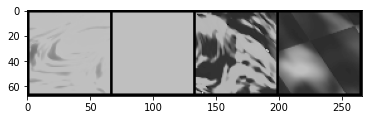

Array shape:  torch.Size([16, 3, 64, 64]) dtype: torch.float32
Array stat: max: 1.0, min: 0.0, mean: 0.3016913831233978, std: 0.26691973209381104


In [10]:
dataiter = iter(trainloader)
comp, Y = dataiter.next()
imshow(torchvision.utils.make_grid(Y[:4]))
imshow(torchvision.utils.make_grid(comp[:4, 0:1]), rescale=False)
imshow(torchvision.utils.make_grid(comp[:4, 1:2]), rescale=False)
imshow(torchvision.utils.make_grid(comp[:4, 2:3]), rescale=False)
print_stat(comp)

Array shape:  torch.Size([200, 3, 64, 64]) dtype: torch.float32

Array stat: max: 1.0, min: 0.0, mean: 0.3200840353965759, std: 0.25610223412513733

*color encoder*

* derive gt feature Y_comp

In [11]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def deconv4x4(in_planes, out_planes, stride=2):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=stride, padding=1, bias=True)
    
class colorEncoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(colorEncoder, self).__init__()
        '''encoder'''
        self.encoder = nn.Sequential(
            conv3x3(in_planes, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, feature_planes, 2),
            nn.ReLU(inplace = True),
        )
    def forward(self, x):
        features = self.encoder(x)
        return features

class colorDecoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(colorDecoder, self).__init__()
        '''decoder'''
        self.decoder = nn.Sequential(
            deconv4x4(feature_planes, 64),
            nn.ReLU(inplace = True),
            deconv4x4(64, 32),
            nn.ReLU(inplace = True),
            deconv4x4(32, in_planes)
        )
    def forward(self, x):
        x = self.decoder(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
in_planes = 3
feature_planes = 128
encoder = colorEncoder(in_planes, feature_planes).to(device)
decoder = colorDecoder(in_planes, feature_planes).to(device)
state_dict = torch.load('color_ae_on_512_synthetic.pt')
encoder_dict = {k: v for k, v in state_dict.items() if "encoder" in k}
decoder_dict = {k: v for k, v in state_dict.items() if "decoder" in k}
encoder.load_state_dict(encoder_dict)
decoder.load_state_dict(decoder_dict)

<All keys matched successfully>

In [12]:
encoder.eval()
with torch.no_grad():
    feature = encoder(((Y - 1.3)/1.4).to(device))
    print_stat(feature)

Array shape:  torch.Size([16, 128, 64, 64]) dtype: torch.float32
Array stat: max: 6.009289264678955, min: 0.0, mean: 0.43702462315559387, std: 0.4668333828449249


Array shape:  torch.Size([200, 128, 64, 64]) dtype: torch.float32

Array stat: max: 7.533452987670898, min: 0.0, mean: 0.4217613637447357, std: 0.4524295926094055

## featureDemosaicNet
* net input: compressed features (64x64x3)
* net output: compressed features (64x64x128)

In [13]:
class featureDemosaicNet(nn.Module):
    def __init__(self):
        super(featureDemosaicNet, self).__init__()
        self.layers = nn.Sequential(
            conv3x3(3, 64),
            nn.ReLU(inplace = True),
            conv3x3(64, 64),
            nn.ReLU(inplace = True),
            conv3x3(64, 256),
            nn.ReLU(inplace = True),
            conv3x3(256, 128),
            nn.ReLU(inplace = True),
            conv3x3(128, 128)
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        return self.layers(x)

In [14]:
model = featureDemosaicNet().to(device)
print(model)
print_model_params(model)

featureDemosaicNet(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)
#total params: 629056 | #trainable params: 629056


In [15]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 5e-4)

In [16]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, Y = data
        inputs = inputs.to(device)
        Y = Y.to(device)
        with torch.no_grad():
            targets = encoder((Y - 1.3)/1.4).detach()
        
        #normalize
        inputs = (inputs - 0.32)/0.25

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('epoch %d -- loss: %.3f' %
                (epoch+1, running_loss/(i+1)))
    running_loss = 0.0

print('Finished Training')

epoch 1 -- loss: 0.093
epoch 2 -- loss: 0.061
epoch 3 -- loss: 0.054
epoch 4 -- loss: 0.052
epoch 5 -- loss: 0.050
epoch 6 -- loss: 0.048


KeyboardInterrupt: ignored

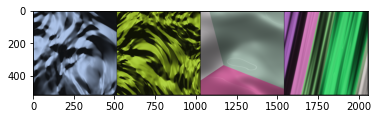

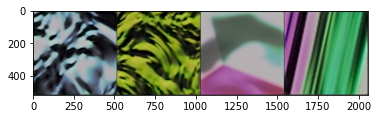

In [19]:
dataiter = iter(testloader)
comp, Y = dataiter.next()
outputs = model(((comp - 0.32)/0.25).to(device)).detach()
Yhat = decoder(outputs).detach().cpu()*1.4+1.3
# show images
imshow(torchvision.utils.make_grid(Y[:4]))
imshow(torchvision.utils.make_grid(Yhat[:4]))

In [21]:
torch.save(model.state_dict(), 'featureDemosaicNet.pth')